In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json._normalize import nested_to_record

%matplotlib inline
import wandb, os
import numpy as np
from omegaconf import OmegaConf

## 1. Get data from wandb or load locally cache file

In [2]:
pull_from_wandb = False
metric_name = "AUC"
temporal_metric_name = "Temporal (OVR) AUC"
sample_name = "Number of Train Samples"
seed_name = "run_seed"
structured_name = "Structured Features Baseline"
text_name = "Clinical Note + NYUTron"

In [ ]:
if pull_from_wandb:
    api = wandb.Api()

    def extract_relevant_df(name, df):
        print(f"extracting df for {name}")
        if name == "insurance_denial_w_time_task2_only":
            df["year"] = df["name"].apply(lambda x: int(x.split("_")[-4]))
            df = df.rename(
                columns={
                    "data/num_train_samples": sample_name,
                    "test/roc_auc": metric_name,
                    "run/seed": seed_name,
                    "temporal_test/roc_auc": temporal_metric_name,
                }
            )
            res = df
            res["task"] = "Insurance denial"
            res["data"] = text_name
            res = res.reset_index()
        elif name == "structured_insurance_denial_w_time":
            res = df[["n_samples", "seed", "same-time test auc", "temporal test auc"]]
            res = res.rename(
                columns={
                    "n_samples": sample_name,
                    "same-time test auc": metric_name,
                    "seed": seed_name,
                    "temporal test auc": temporal_metric_name,
                }
            )
            res["task"] = "Insurance denial"
            res["data"] = structured_name
        elif name == "in_hospital_mortality":
            print(list(df.columns))
            res = df[
                [
                    "data/num_train_samples",
                    "test/roc_auc",
                    "run/seed",
                    "temporal_test/roc_auc",
                ]
            ]
            print(res)
            res = res.rename(
                columns={
                    "data/num_train_samples": sample_name,
                    "test/roc_auc": metric_name,
                    "run/seed": seed_name,
                    "temporal_test/roc_auc": temporal_metric_name,
                }
            )
            res["task"] = "In-hospital mortality"
            res["data"] = text_name
        elif name == "comorbidity_quantile_temmporal":
            res = df[["eval/ovr_roc_auc"]]
            print(res)
            res = res.rename(columns={"eval/ovr_roc_auc": temporal_metric_name})
            res["task"] = "Binned Comorbidity"
            res["data"] = text_name
            res[sample_name] = 256676
        elif name == "structured_comorbidity_quantile":
            res = df[["n_samples", "seed", "same-time test auc", "temporal test auc"]]
            res = res.rename(
                columns={
                    "n_samples": sample_name,
                    "same-time test auc": metric_name,
                    "temporal test auc": temporal_metric_name,
                    "seed": seed_name,
                }
            )
            res["task"] = "Comorbidity Quantile"
            res["data"] = structured_name
        elif name == "structured_mortality":
            res = df[["n_samples", "seed", "same-time test auc", "temporal test auc"]]
            res = res.rename(
                columns={
                    "n_samples": sample_name,
                    "same-time test auc": metric_name,
                    "temporal test auc": temporal_metric_name,
                    "seed": seed_name,
                }
            )
            res["task"] = "In-hospital mortality"
            res["data"] = structured_name
        elif name == "los_binary":
            res = df[
                [
                    "data/num_train_samples",
                    "test/roc_auc",
                    "temporal_test/roc_auc",
                    "run/seed",
                ]
            ]
            res = res.rename(
                columns={
                    "data/num_train_samples": sample_name,
                    "test/roc_auc": metric_name,
                    "temporal_test/roc_auc": temporal_metric_name,
                    "run/seed": seed_name,
                }
            )
            res["task"] = "LOS Binary"
            res["data"] = text_name
        elif name == "structured_los":
            res = df[["n_samples", "seed", "same-time test auc", "temporal test auc"]]
            res = res.rename(
                columns={
                    "n_samples": sample_name,
                    "same-time test auc": metric_name,
                    "temporal test auc": temporal_metric_name,
                    "seed": seed_name,
                }
            )
            res["task"] = "LOS Binary"
            res["data"] = structured_name
        elif name == "comorbidity_quantile":
            res = df[
                [
                    "data/num_train_samples",
                    "test/ovr_roc_auc",
                    "temporal_test/roc_auc",
                    "run/seed",
                ]
            ]  #
            res = res.rename(
                columns={
                    "data/num_train_samples": sample_name,
                    "test/ovr_roc_auc": metric_name,
                    "temporal_test/ovr_roc": temporal_metric_name,
                    "run/seed": seed_name,
                }
            )
            res["task"] = "Binned Comorbidity"
            res["data"] = text_name
        elif name == "clinical_vs_wiki-new-fixed":
            res = df[
                [
                    "data/num_train_samples",
                    "test/roc_auc",
                    "test/temporal_roc_auc",
                    "pretrained",
                ]
            ]
            res = res[res["pretrained"] == "clinical_new"]
            res = res.rename(
                columns={
                    "data/num_train_samples": sample_name,
                    "test/roc_auc": metric_name,
                    "test/temporal_roc_auc": temporal_metric_name,
                }
            )
            res["task"] = "Readmission"
            res["data"] = text_name
            res = res[
                [
                    sample_name,
                    metric_name,
                    temporal_metric_name,
                    "task",
                    "data",
                    seed_name,
                ]
            ]
        elif name == "legacy_readmission-fixed-label-new":
            res = df[["n_samples", "seed", "same-time test auc", "temporal test auc"]]
            res = res.rename(
                columns={
                    "n_samples": sample_name,
                    "same-time test auc": metric_name,
                    "temporal test auc": temporal_metric_name,
                    "seed": seed_name,
                }
            )
            res["task"] = "Readmission"
            res["data"] = structured_name
        else:
            raise RuntimeError(f"name {name} not implemented!")
        return res

    def get_project_data(username, project_name):
        save_name = project_name.replace("/", "_") + ".csv"
        if (
            save_name == "clinical_vs_wiki-new-fixed.csv"
            or save_name == "legacy_readmission-fixed-label-new"
        ):
            if os.path.exists(save_name):
                print(f"returning for readmission task")
                # readmission log is very large & static, so we load from cache
                return pd.read_csv(save_name)
        runs = api.runs(f"{username}/{project_name}")
        summary_list = []
        config_list = []
        name_list = []
        for run in runs:
            # run.summary are the output key/values like accuracy.
            # We call ._json_dict to omit large files
            summary_list.append(run.summary._json_dict)

            # run.config is the input metrics.
            # We remove special values that start with _.
            conf = nested_to_record(run.config, sep="/")
            config = {k: v for k, v in conf.items() if not k.startswith("_")}
            config_list.append(config)

            # run.name is the name of the run.
            name_list.append(run.name)

        summary_df = pd.DataFrame.from_records(summary_list)
        config_df = pd.DataFrame.from_records(config_list)
        name_df = pd.DataFrame({"name": name_list})
        data_df = pd.concat([name_df, config_df, summary_df], axis=1)

        data_df.to_csv(f"{save_name}.csv")
        print(f"saved data df to {save_name}")
        return data_df

In [4]:
if pull_from_wandb:
    project_names = [
        "structured_insurance_denial_w_time",
        "insurance_denial_w_time_task2_only",
        "structured_los_quantile_new",
        "los_quantile",
        "clinical_vs_wiki-new-fixed",
        "legacy_readmission-fixed-label-new",
        "in_hospital_mortality",
        "structured_mortality",
        "comorbidity_quantile_temmporal",
        "structured_comorbidity_quantile",
    ]

    lavender_spaces = [
        "clinical_vs_wiki-new-fixed",
        "legacy_readmission-fixed-label-new",
        "insurance_denial_w_time_task2_only",
        "structured_insurance_denial_w_time",
        "los_quantile",
        "in_hospital_mortality",
        "structured_comorbidity_quantile",
    ]
    res = {}
    plot_res = {}

    def fill_res(project_name):
        if project_name in lavender_spaces:
            username = "lavender"
        else:
            username = "olab-pau"
        res[project_name] = get_project_data(username, project_name)
        plot_res[project_name] = extract_relevant_df(project_name, res[project_name])

    for project_name in project_names:
        fill_res(project_name)

In [5]:
if pull_from_wandb:
    # examine plot_res
    print(plot_res.keys())
    print("***********")
    print(plot_res["los_quantile"])
    print("***********")
    for key in plot_res.keys():
        print(plot_res[key])
        print("=======")
    print("***********")
    print(plot_res["structured_mortality"])

### combine the df

In [6]:
if pull_from_wandb:
    # combine dfs
    keep_cols = [sample_name, temporal_metric_name, seed_name, "task", "data"]
    plot_df = pd.concat(
        [plot_res[key][keep_cols] for key in plot_res.keys()], ignore_index=True
    )
    print(plot_res["structured_mortality"][keep_cols])
    max_sample_dict = {
        "Insurance denial": 41842,
        "In-hospital mortality": 334515,
        "LOS Binary": 334515,
        "LOS": 334515,  # removed Binned
        "Comorbidity Binary": 288100,
        "Binned Comorbidity": 256676,
        "Comorbidity 5-Bin": 288100,
        "Readmission": 362259,
    }

    full_dfs = []
    for task, full_size in max_sample_dict.items():
        task_df = plot_df[plot_df.task == task]
        full_dfs.append(task_df[task_df[sample_name] == max_sample_dict[task]])

    full_df = pd.concat(full_dfs, ignore_index=True)
    print(full_df)

    operational_tasks = ["Insurance denial", "LOS"]
    clinical_tasks = ["In-hospital mortality", "Readmission"]

In [7]:
if pull_from_wandb:

    def sort_order(df):
        data_order = [text_name, structured_name]
        df["data"] = pd.Categorical(df["data"], categories=data_order, ordered=True)
        df = df.sort_values(by="data")
        return df

    def sort_clinical(df):
        task_order = clinical_tasks
        df["task"] = pd.Categorical(df["task"], categories=clinical_tasks, ordered=True)
        df = df.sort_values(by="task")
        return df

    operational_df = full_df[full_df.task.isin(operational_tasks)]
    operational_df = sort_order(operational_df)
    print(operational_df)
    operational_df.to_csv("raw_data/2c_ops.csv")
    print(operational_df[operational_df.task == "Insurance denial"])
    print("***********")

    clinical_df = sort_order(full_df[full_df.task.isin(clinical_tasks)])
    clinical_df = sort_clinical(clinical_df)
    clinical_df.to_csv("raw_data/2b_clinical.csv")
    print(clinical_df)
else:
    operational_df = pd.read_csv("raw_data/2c_ops.csv", index_col=0)
    clinical_df = pd.read_csv("raw_data/2b_clinical.csv", index_col=0)

In [8]:
def examine_stats(operational_df, clinical_df):
    print(f"****ops median*******")
    print(operational_df.groupby(["task", "data"]).median())
    print(f"****ops std*******")
    print(operational_df.groupby(["task", "data"]).std())
    print(f"LOS gain: {0.786916 - 0.664144}, mortality gain: {0.872335-0.725463}")
    print(f"****clinical median*******")
    print(clinical_df.groupby(["task", "data"]).median())
    print(f"****clinical std*******")
    print(clinical_df.groupby(["task", "data"]).std())
    print(
        f"readmission gain: {0.798681 - 0.745123}, mortality gain: {0.949323-0.875059}"
    )


examine_stats(operational_df, clinical_df)

****ops median*******
                                               Number of Train Samples  \
task             data                                                    
Insurance denial Clinical Note + NYUTron                       41842.0   
                 Structured Features Baseline                  41842.0   
LOS              Clinical Note + NYUTron                      334515.0   
                 Structured Features Baseline                 334515.0   

                                               Temporal (OVR) AUC  run_seed  
task             data                                                        
Insurance denial Clinical Note + NYUTron                 0.872335      24.0  
                 Structured Features Baseline            0.725463      21.0  
LOS              Clinical Note + NYUTron                 0.786916      24.0  
                 Structured Features Baseline            0.664144      21.0  
****ops std*******
                                              

## 2. start plotting

In [9]:
palette = sns.color_palette("Set2", 10)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

In [10]:
plt_conf = OmegaConf.load("nature.yaml")
slack = 5
single_col_width = 89 - slack
double_col_width = 183 - slack
height = 89 - slack


def mm_to_inch(mm):
    return mm / 25.4


print(plt_conf)

{'axes.labelsize': 7, 'xtick.labelsize': 7, 'ytick.labelsize': 7, 'legend.fontsize': 7, 'font.size': 7, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial, Helvetica', 'mathtext.fontset': 'dejavusans', 'axes.linewidth': 0.5, 'grid.linewidth': 0.5, 'lines.linewidth': 1.0, 'lines.markersize': 3, 'pdf.fonttype': 42, 'ps.fonttype': 42, 'svg.fonttype': 'none'}


/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_16590/1502816032.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=operational_df, x='task',y=temporal_metric_name,hue='data',estimator=np.median, ci='sd',
/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_16590/1502816032.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('AIP_plots/2c.eps', format='eps', box_inches='tight')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_16590/1502816032.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('AIP_plots/2c.pdf', format='pdf', box_inche

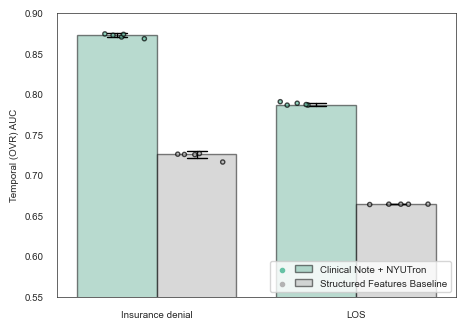

In [11]:
from matplotlib.legend_handler import HandlerTuple

np.random.seed(53)
# reference: https://stackoverflow.com/questions/69315871/how-to-overlay-data-points-on-a-barplot-with-a-categorical-axis
sns.set(font_scale=2, style="white")
plt.rcParams.update(plt_conf)
plt.rcParams["figure.figsize"] = (
    mm_to_inch(double_col_width / 3 * 2),
    mm_to_inch(height),
)
ax = sns.barplot(
    data=operational_df,
    x="task",
    y=temporal_metric_name,
    hue="data",
    estimator=np.median,
    ci="sd",
    palette=[palette[0], palette[7]],
    edgecolor="black",
    errcolor="black",
    capsize=0.1,
    errwidth=1,
    alpha=0.5,
)
sns.stripplot(
    x="task",
    y=temporal_metric_name,
    hue="data",
    data=operational_df,
    dodge=True,
    alpha=0.7,
    palette=[palette[0], palette[7]],
    ax=ax,
    s=3,
    jitter=0.4,
    linewidth=1,
    edgecolor="black",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=[(handles[idx], handles[idx + 2]) for idx in range(2)],
    labels=labels[:2],
    loc="lower right",
    handlelength=4,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)
plt.ylim([0.55, 0.9])
plt.xlabel("")
plt.tight_layout()
plt.savefig("AIP_plots/2c.eps", format="eps", box_inches="tight")
plt.savefig("AIP_plots/2c.pdf", format="pdf", box_inches="tight")
plt.savefig("AIP_plots/2c.svg", format="svg", box_inches="tight")

/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_16590/4094483902.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax=sns.barplot(data=clinical_df, x='task',y=temporal_metric_name,hue='data',estimator=np.median, ci='sd',
/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_16590/4094483902.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('AIP_plots/2b_left.eps', format='eps', box_inches='tight')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/var/folders/5v/561pm5gx1h9fgr_77mp6091m0000gn/T/ipykernel_16590/4094483902.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('AIP_plots/2b_left.pdf', format='pdf', box_

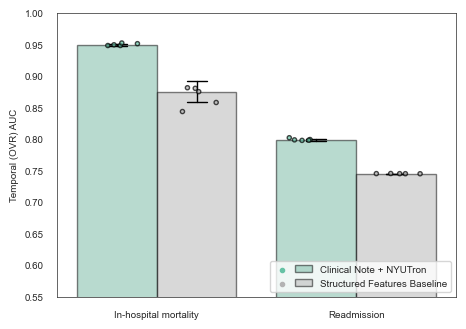

In [12]:
sns.set(font_scale=2, style="white")
np.random.seed(53)
plt.rcParams.update(plt_conf)
plt.rcParams["figure.figsize"] = (
    mm_to_inch(double_col_width / 3 * 2),
    mm_to_inch(height),
)
ax = sns.barplot(
    data=clinical_df,
    x="task",
    y=temporal_metric_name,
    hue="data",
    estimator=np.median,
    ci="sd",
    palette=[palette[0], palette[7]],
    edgecolor="black",
    errcolor="black",
    capsize=0.1,
    errwidth=1,
    alpha=0.5,
)
sns.stripplot(
    x="task",
    y=temporal_metric_name,
    hue="data",
    data=clinical_df,
    dodge=True,
    alpha=0.7,
    palette=[palette[0], palette[7]],
    ax=ax,
    s=3,
    jitter=0.3,
    linewidth=1,
    edgecolor="black",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=[(handles[idx], handles[idx + 2]) for idx in range(2)],
    labels=labels[:2],
    loc="lower right",
    handlelength=4,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)
plt.ylim([0.55, 1])
plt.xlabel("")
plt.tight_layout()
plt.savefig("AIP_plots/2b_left.eps", format="eps", box_inches="tight")
plt.savefig("AIP_plots/2b_left.pdf", format="pdf", box_inches="tight")